# Rayleigh Distribution

In this notebook, I'll draw eccentricities from a Rayleigh distribution (instead of uniform distribution) and compare the fit eccentricity distribution to the true Rayleigh distribution.

I'll assume e and w are independent and draw from a uniform w distribution. (think about this later)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

I'll fit the transits with `emcee`, which takes a number of walkers, steps, and steps to discard. I'm defining them here so I can create my planet parameter distributions (period, rp/rs, a/rs, inclination) to be the proper length.

In [2]:
nwalk = 64
nsteps_d = 3000
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [3]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [4]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

In [6]:
# ph.fit_isochrone_lum() steps through all MESA isochrones and matches the ones that fit the given parameters
iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from crashing)
iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

100%|██████████| 738479/738479 [01:17<00:00, 9531.19it/s] 


In [7]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [8]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

In [9]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


In [11]:
pdist = np.random.normal(period, np.mean((abs(period_uerr), abs(period_lerr))), len(rho_star))

a_rs_gaia = ph.get_a_rs(rho_star, pdist)
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)

a_rs_guess = np.mean(a_rs_gaia)

#a/Rs priors to put in transit fitting
a_rs_priors = [a_rs_guess-10*np.std(a_rs_gaia), a_rs_guess+10*np.std(a_rs_gaia)]

Using sigma=0.24 from https://arxiv.org/pdf/1807.00549.pdf

In [41]:
# e and w drawn randomly from unifrom distribution

n = 20

e_rand = np.random.rayleigh(scale=0.24, size=n)
w_rand = np.random.uniform(-90.0, 90.0, size=n)

(array([1., 1., 0., 1., 0., 1., 2., 0., 1., 2., 1., 1., 2., 2., 2., 0., 0.,
        0., 1., 2.]),
 array([0.07792564, 0.10021298, 0.12250031, 0.14478764, 0.16707497,
        0.1893623 , 0.21164964, 0.23393697, 0.2562243 , 0.27851163,
        0.30079896, 0.32308629, 0.34537363, 0.36766096, 0.38994829,
        0.41223562, 0.43452295, 0.45681028, 0.47909762, 0.50138495,
        0.52367228]),
 <a list of 20 Patch objects>)

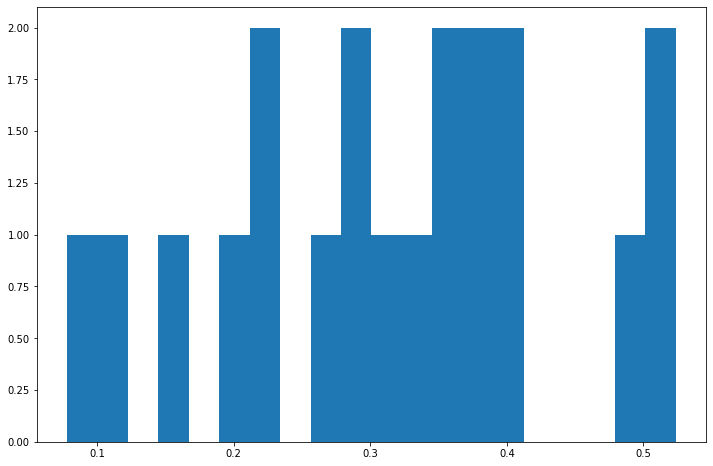

In [42]:
plt.hist(e_rand, bins=20)

In [43]:
# initialize arrays w zeros

gmeans = np.zeros(n)
gsigs = np.zeros(n)
es_best = np.zeros(n)
ws_best = np.zeros(n)
zscores = np.zeros((n, 2))

In [44]:
print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(n):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    
    dr = 'e_' + str(e_rand[j]) + '_w_' + str(w_rand[j])
    direct = 'plots/' + dr + '/'
    
    if not os.path.exists(direct):
        os.mkdir(direct)
    
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = ph.photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j], noise=0.00005)

    # nsteps kept 1000, nwalkers 32, len(result) 32000
    
    guess_transit = np.array([ph.bls(ttime, tflux), 0.036066, a_rs_guess, 89.9, 90.0])
    guess_ew = np.array([0, 0])
    
    beste, bestw, edist, wdist, gs, g_mean, g_sigmas, zsc = ph.photo_fit(ttime, tflux, tflux_err, guess_transit, guess_ew, rho_star, e_rand[j], w_rand[j], direct, nwalk, nsteps_d, ndiscard_d) 
    gmeans[j] = g_mean
    gsigs[j] = np.mean(g_sigmas)
    es_best[j] = beste
    ws_best[j] = bestw
    zscores[j] = np.mean(zsc)
    print("Best e: ", beste)



Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.4002428821780194 w:  35.28671519197813


100%|██████████| 3000/3000 [08:20<00:00,  5.99it/s]


Fit params:
Period (days):  4.838788389424597
Rp/Rs:  0.035802619616081555
a/Rs:  42.5278378653284
i (deg):  89.75209691093134


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 77/5000 [00:00<00:06, 766.47it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 574.68it/s]


Best e:  0.365975279179549
e:  0.22279729947227442 w:  16.456977310765254


100%|██████████| 3000/3000 [07:04<00:00,  7.06it/s]


Fit params:
Period (days):  4.837972057526352
Rp/Rs:  0.03629611949091035
a/Rs:  33.68781153894084
i (deg):  89.50623347601527


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 74/5000 [00:00<00:06, 736.13it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 747.83it/s]


Best e:  0.1350266110460495
e:  0.3599350564761114 w:  26.816915349926973


100%|██████████| 3000/3000 [06:22<00:00,  7.84it/s]


Fit params:
Period (days):  4.836870953815902
Rp/Rs:  0.035724737051166904
a/Rs:  40.09893408578523
i (deg):  89.812043289459


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 109/5000 [00:00<00:09, 541.58it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 690.32it/s]


Best e:  0.3233843860167839
e:  0.10368049642449839 w:  -80.89375568188923


100%|██████████| 3000/3000 [06:20<00:00,  7.88it/s]


Fit params:
Period (days):  4.838170813441938
Rp/Rs:  0.03616359283573582
a/Rs:  28.555102422931245
i (deg):  89.57154123490744


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 57/5000 [00:00<00:08, 566.49it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:16<00:00, 298.70it/s]


Best e:  0.2351519799177657
e:  0.07792564490847365 w:  41.251655845051516


100%|██████████| 3000/3000 [07:52<00:00,  6.35it/s]


Fit params:
Period (days):  4.838140806759669
Rp/Rs:  0.03613266797419475
a/Rs:  33.31960309991482
i (deg):  89.60373264488702


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 52/5000 [00:00<00:09, 517.82it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 595.48it/s]


Best e:  0.1265185532252685
e:  0.5236722795566408 w:  82.52696181433853


100%|██████████| 3000/3000 [08:24<00:00,  5.94it/s]


Fit params:
Period (days):  4.855920282475397
Rp/Rs:  0.03457919956413567
a/Rs:  56.38418752758753
i (deg):  89.8385073159808


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 67/5000 [00:00<00:07, 662.54it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:09<00:00, 552.80it/s]


Best e:  0.5840835043605495
e:  0.22209920904956415 w:  12.0125756916037


100%|██████████| 3000/3000 [08:26<00:00,  5.93it/s]


Fit params:
Period (days):  4.838123136405636
Rp/Rs:  0.03619876251456646
a/Rs:  33.548424556804555
i (deg):  89.57246411181961


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 65/5000 [00:00<00:07, 642.83it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 605.08it/s]


Best e:  0.13414288041774097
e:  0.38704113264206785 w:  -6.048825758716973


100%|██████████| 3000/3000 [07:18<00:00,  6.85it/s]


Fit params:
Period (days):  4.838113556449994
Rp/Rs:  0.03614507503831003
a/Rs:  32.79698375290381
i (deg):  89.59294141329005


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 99/5000 [00:00<00:10, 471.65it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:09<00:00, 516.15it/s]


Best e:  0.11597321281017178
e:  0.3112583345338624 w:  -59.999879807843556


100%|██████████| 3000/3000 [06:54<00:00,  7.24it/s]


Fit params:
Period (days):  4.838139453945126
Rp/Rs:  0.03611742948584222
a/Rs:  24.836612341618853
i (deg):  89.74500714257607


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 52/5000 [00:00<00:09, 516.37it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:09<00:00, 549.23it/s]


Best e:  0.3954073999352442
e:  0.29343028857847525 w:  -29.657898256534516


100%|██████████| 3000/3000 [06:42<00:00,  7.45it/s]


Fit params:
Period (days):  4.838060786479483
Rp/Rs:  0.036151292282244965
a/Rs:  28.910686070735217
i (deg):  89.76946712192122


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 64/5000 [00:00<00:07, 636.04it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:10<00:00, 459.18it/s]


Best e:  0.21606730837624455
e:  0.48877276042375406 w:  -4.34179958905932


100%|██████████| 3000/3000 [07:17<00:00,  6.86it/s]


Fit params:
Period (days):  4.838146547190684
Rp/Rs:  0.036178505735180055
a/Rs:  35.29887751149859
i (deg):  89.76070353736901


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 122/5000 [00:00<00:08, 601.86it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 572.38it/s]


Best e:  0.17764080631092383
e:  0.5202477514245939 w:  71.34401594821776


100%|██████████| 3000/3000 [08:20<00:00,  5.99it/s]


Fit params:
Period (days):  4.836402789421223
Rp/Rs:  0.03590704898555898
a/Rs:  54.092946804433296
i (deg):  89.71548747360205


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 51/5000 [00:00<00:09, 504.32it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:10<00:00, 465.46it/s]


Best e:  0.558539098473345
e:  0.16410350773827545 w:  37.4301510184698


100%|██████████| 3000/3000 [08:58<00:00,  5.57it/s]


Fit params:
Period (days):  4.838162712705204
Rp/Rs:  0.03608830981527247
a/Rs:  35.76389378316504
i (deg):  89.78005845955813


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 52/5000 [00:00<00:09, 515.25it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:15<00:00, 315.05it/s]


Best e:  0.18229991721840155
e:  0.2961815880930915 w:  -82.2369610577862


100%|██████████| 3000/3000 [08:25<00:00,  5.93it/s]  


Fit params:
Period (days):  4.838097268673159
Rp/Rs:  0.036021206165291496
a/Rs:  24.00449329387601
i (deg):  89.76373094036944


  0%|          | 0/5000 [00:00<?, ?it/s]

-------MCMC------


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:15<00:00, 322.13it/s]


Best e:  0.42279600849849275
e:  0.2046981454626246 w:  -22.467818643615857


100%|██████████| 3000/3000 [07:10<00:00,  6.97it/s]


Fit params:
Period (days):  4.838093735525963
Rp/Rs:  0.036241363797712374
a/Rs:  29.99915307240712
i (deg):  89.6179493834156


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 78/5000 [00:00<00:06, 773.13it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 892.70it/s]


Best e:  0.16465150075150753
e:  0.34818852628177577 w:  48.80967072614649


100%|██████████| 3000/3000 [07:47<00:00,  6.42it/s]


Fit params:
Period (days):  4.838129167165861
Rp/Rs:  0.03623273421248583
a/Rs:  40.5828768821468
i (deg):  89.48949861010436


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 64/5000 [00:00<00:07, 629.14it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 614.27it/s]


Best e:  0.32186458362802695
e:  0.27328165881805133 w:  45.429573927131884


100%|██████████| 3000/3000 [07:21<00:00,  6.80it/s]


Fit params:
Period (days):  4.838103832226866
Rp/Rs:  0.036212170244792556
a/Rs:  39.90233202236646
i (deg):  89.77561391356701


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 53/5000 [00:00<00:09, 512.25it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:11<00:00, 440.15it/s]


Best e:  0.3286188883028864
e:  0.368620953910348 w:  35.5399298911465


100%|██████████| 3000/3000 [08:39<00:00,  5.77it/s]


Fit params:
Period (days):  4.838091530656267
Rp/Rs:  0.036024295575380755
a/Rs:  41.40459663744314
i (deg):  89.70823972398657


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 73/5000 [00:00<00:06, 719.91it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 645.54it/s]


Best e:  0.3527578515838694
e:  0.3255359009825713 w:  46.90391742366211


100%|██████████| 3000/3000 [07:07<00:00,  7.02it/s]


Fit params:
Period (days):  4.833467533017811
Rp/Rs:  0.03449505745931129
a/Rs:  41.56732639046855
i (deg):  89.81050634314428


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 44/5000 [00:00<00:11, 435.83it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:13<00:00, 374.95it/s]


Best e:  0.3482974539939486
e:  0.3961028854241986 w:  52.88326458387232


100%|██████████| 3000/3000 [07:04<00:00,  7.07it/s]


Fit params:
Period (days):  4.838100116049707
Rp/Rs:  0.03595293992405595
a/Rs:  45.91839108202921
i (deg):  89.79438947360953


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 55/5000 [00:00<00:09, 547.33it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 563.12it/s]


Best e:  0.4336025328278377


In [45]:
es_best = np.array(es_best)
ws_best = np.array(ws_best)
zscores = np.array(zscores)

np.savetxt('plots/results/rayleigh_32521_e_best.csv', es_best, delimiter=',')
np.savetxt('plots/results/rayleigh_32521_w_best.csv', ws_best, delimiter=',')
np.savetxt('plots/results/rayleigh_32521_e_rand.csv', e_rand, delimiter=',')
np.savetxt('plots/results/rayleigh_32521_w_rand.csv', w_rand, delimiter=',')
np.savetxt('plots/results/rayleigh_32521_zscores_e.csv', abs(zscores[:,0]), delimiter=',')
np.savetxt('plots/results/rayleigh_32521_zscores_w.csv', abs(zscores[:,1]), delimiter=',')

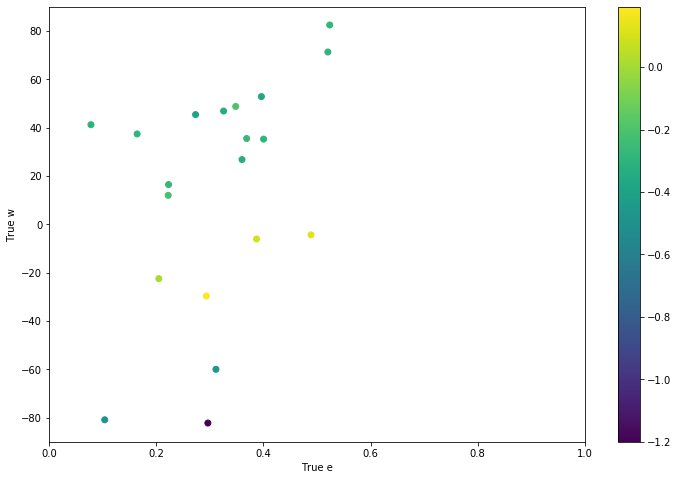

In [46]:
plt.scatter(e_rand, w_rand, c=zscores[:,0])
plt.xlim(0.0, 1.0)
plt.ylim(-90., 90.)
plt.xlabel('True e')
plt.ylabel('True w')
plt.colorbar()

(array([1., 0., 0., 0., 0., 4., 9., 2., 1., 3.]),
 array([-1.20026763, -1.06093565, -0.92160367, -0.78227168, -0.6429397 ,
        -0.50360772, -0.36427574, -0.22494376, -0.08561178,  0.0537202 ,
         0.19305218]),
 <a list of 10 Patch objects>)

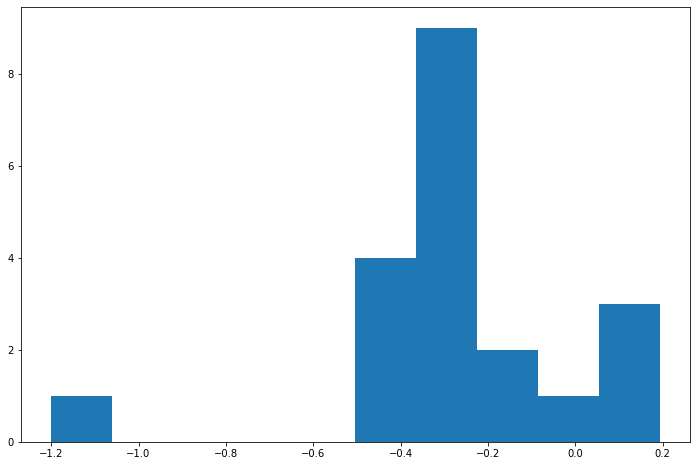

In [48]:
plt.hist(zscores[:,0])